# Table of Contents

### 1. [Import Necessary Libraries](#Import-Necessary-Libraries)
### 2. [Understanding the Data](#Understanding-the-Data) 
### 3. [Identify correlations between columns and survival](#Identify-correlations-between-columns-and-survival)
### 4. [Logistic Regression](#Logistic-Regression)
### 5. [Write to Submission File](#Write-To-Submission-File)

<a name="headers"/>

# Import Necessary Libraries
Import the modules necessary for the analysis

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import csv


from sklearn import linear_model
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

# Understanding the Data
Read the input files and show their attributes. I will reference this throughout working on this project

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

display(train_df.info())
display(train_df.describe())
#display(test_df.info())
#display(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [32]:
display(train_df.describe(include = ['O']))

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dennis, Mr. Samuel",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


Identify which columns have null values. We will need to fill in these values before performing some of the modeling later on. It is nice to know which data we can use to infer the missing values.

In [33]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Identify correlations between columns and survival
### Gender
First we will consider the effect that gender has on survival.

In [4]:
print('Pearson Coefficient\n',train_df.corr(method='pearson'))

Pearson Coefficient
              PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


In [35]:
alive_train_df = train_df[train_df['Survived'] == 1]
dead_train_df = train_df[train_df['Survived'] == 0]
display(alive_train_df.describe(include = ['O']))
display(train_df["Sex"].isnull().sum()) # there are no null values in this set

,Name,Sex,Ticket,Cabin,Embarked
count,342,342,342,136,340
unique,342,2,260,101,3
top,"Reynaldo, Ms. Encarnacion",female,1601,B96 B98,S
freq,1,233,5,4,217


0

In [36]:
display('Survival % by sex versus all passengers',train_df.groupby(['Sex'])['Survived'].mean())
display('Distribution of genders for all passengers',train_df['Sex'].value_counts())
display('Distribution of genders for survivors',alive_train_df['Sex'].value_counts())

'Survival % by sex versus all passengers'

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

'Distribution of genders for all passengers'

male      577
female    314
Name: Sex, dtype: int64

'Distribution of genders for survivors'

female    233
male      109
Name: Sex, dtype: int64

As we can see, females made up about 68.1% of the surviving people. Furthermore, there were far fewer females in this set than males, only 314 compared to 577 males. Considering this, females had a 74% chance of survival compared to the male's 19%. 

### Pclass
Now consider if PClass had an effect on survival.

In [37]:
display(alive_train_df.groupby(['Pclass'], as_index = True)['Survived'].count())
display(train_df['Pclass'].isnull().sum()) #No null values in this set

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

0

We can see that Pclass 1 is has the highest number of survivors, but this is meaningless without incorporating how many people were in each class. We need to normalize this value and determine the chance of surviving per Pclass.

In [38]:
display(train_df.groupby(['Pclass'])['Survived'].mean())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

The survival chance for the passengers was much higher if they were in a higher class. Passengers in Pclass 1 had a 63% of survival, far more than the passengers in the other classes.

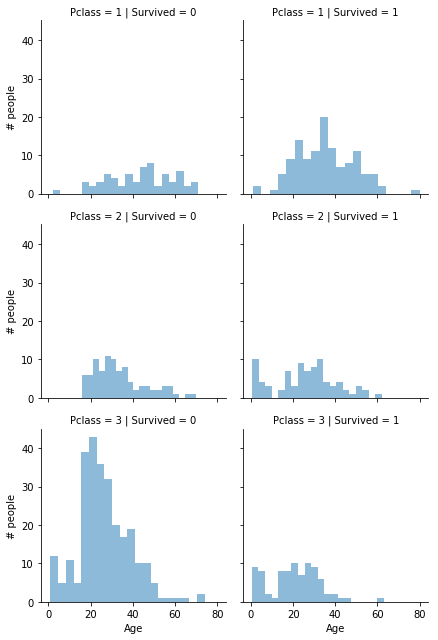

In [39]:
fg = sns.FacetGrid(train_df, col="Survived", row="Pclass")
fg = fg.map(plt.hist, "Age", alpha = .5, bins=20).set_axis_labels("Age", "# people")

Looking at the above figure is a representation of what we discovered earlier. People in Pclass 1 were more likely to survive while people in Pclass 3 were more likely to die. We do have some new information regarding Age in respect to these plots. We can see that age correlates to Pclass. The lower class had mostly 13-39 year olds while the upper class had mostly 24-52 year olds. The mean and standard deviation are listed below this cell.

In [40]:
display(train_df.groupby(['Pclass'])['Age'].mean())
display(train_df.groupby(['Pclass'])['Age'].std())

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Pclass
1    14.802856
2    14.001077
3    12.495398
Name: Age, dtype: float64

### SibSp and Parch
Consider the effect that SibSp and Parch have on survival

In [41]:
display(train_df.groupby(['SibSp'])['Survived'].mean())
display(train_df.groupby(['Parch'])['Survived'].mean())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

The most likely people to survive had a few siblings and a few family members. I believe this is due to parents giving their children spots on the life boats. 


### Age
How did age effect survival rate?

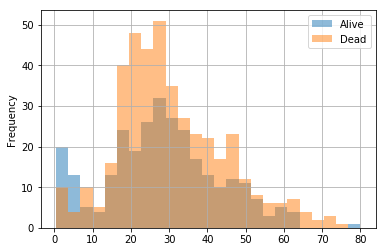

In [56]:
age_survived = pd.DataFrame({'Alive': alive_train_df['Age'], 'Dead': dead_train_df['Age']}
                            ,columns=['Alive', 'Dead']);
plt.figure();
age_survived.plot.hist(bins = 25,alpha=0.5, grid = True);

It is appparent that the very youngest of passengers (<8 yrs) had the highest chance of survival. The people in their 20s had the lowest chance. Near the upper threshold of age, passengers were slightly more likely to survived, but still <50%.

### Cabin
In order to determine how Cabin affected survival, a function needs to be created that can parse through the data and extract the letter and number identifier of each compartment. We will plot this data against the survival count of people in each cabin.

In [7]:
def extractCabinLetter(input_df):
    pass

# Logistic Regression
Now that we are familiar with the data sets and how some of the columns affect survival, apply logistic regression to create a classification algorithm that can help predict the test_df set.

### Hypothesis
Let's run a quick test to make sure that the hypothesis function is working properly. This is also a good representation of how logistic regression uses probabilities to predict whether or not the sample data will be alive or dead. This function equals exactly .5 when x = 0 and is represented by the equation $$ \frac{1} {1 + e^{-x}} $$

In [43]:
def sigmoid(x):
    return 1.0 / (1 + math.exp(-x))

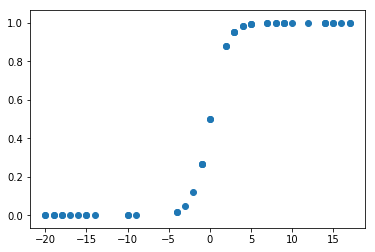

In [44]:
x = []
for i in range(0,50):
    x.append(np.random.randint(-20,20))
test = list(map(lambda b : sigmoid(b), x))
plt.scatter(x,test)

For simplicity, I will only consider a few of the columns at this point. From now on, I will prepare the training data set with the testing data set to ensure they have the same number of features.

In [45]:
model_dict = {
    'PassengerID' : train_df['PassengerId'],
    'Survived' : train_df['Survived'],
    'Sex' : train_df['Sex'],
    'Pclass' : train_df['Pclass'],
    'Age' : train_df['Age'],
    'SibSp' : train_df['SibSp'],
    'Parch' : train_df['Parch']
    }

model_df = pd.DataFrame(model_dict)

final_dict = {
    'PassengerID' : test_df['PassengerId'],    
    'Sex' : test_df['Sex'],
    'Pclass' : test_df['Pclass'],
    'Age' : test_df['Age'],
    'SibSp' : test_df['SibSp'],
    'Parch' : test_df['Parch']
    }

final_df = pd.DataFrame(final_dict)

In [46]:
display(model_df.head(1))
display(final_df.head(1))

,Age,Parch,PassengerID,Pclass,Sex,SibSp,Survived
0,22.0,0,1,3,male,1,0


,Age,Parch,PassengerID,Pclass,Sex,SibSp
0,34.5,0,892,3,male,0


### Eliminating the null data (Fixed)
We cannot execute the model in the current state. The training data still has null and NaN values in it. For now, I am going to eliminate these rows, but I will iteratively improve this solution with future commits. We can not drop rows in the test_df because we need to submit an answer for every passenger. For now, I'll just use the average age for Nan values, butt eventually I would like to perform some mean imputation to get better results

In [47]:
display(model_df.isna().any()) # Shows True for Age, so Age has null values
#model_df = model_df[np.isfinite(model_df['Age'])] #eliminates rows that have Nan
#print("The new length of the data set is", len(model_df))

#final_df.fillna(30, inplace=True)
#final_df.Age.fillna(30, inplace=True)

#final_df.tail(15)
#model_df.head(25)

Age             True
Parch          False
PassengerID    False
Pclass         False
Sex            False
SibSp          False
Survived       False
dtype: bool

### Impute the Nan Ages from Pclass
It was established earlier that Age has Nan values in the columns. Therefore, we must use information that we DO have in order to fill in the Nan values with an int.
From the code above, we have grouped the mean age of the people in each class. We know the mean age of people in each class. mean(Pclass == 1) = 38.23, mean(Pclass == 2) = 29.87, mean(Pclass == 3) = 25.14

In [48]:
pclass_to_age_map = {
    1 : 38.23,
    2 : 29.87,
    3 : 25.14
}

def pClassAgeMap(input_df):
    for i in range(0, len(input_df['Age'])):
        x = input_df.Age[i]
        if np.isnan(x):
            predicted_age = pclass_to_age_map[input_df.Pclass[i]]
            input_df.loc[i,'Age'] = predicted_age
pClassAgeMap(model_df)
pClassAgeMap(final_df)
#display(model_df.head())


### Cast DataFrame columns to type int
In order to use logistic regression, we need to transform the strings that identify gender into integers. We will represent 'female' with a 1 and 'male' with a 0. We also need to drop the target variable from the dataframe, which in this case is  Survived.

In [49]:
mapping = {'female': 1, 'male': 0}
model_df = model_df.replace({'Sex': mapping})
final_df = final_df.replace({'Sex': mapping})

y = model_df['Survived']
model_df = model_df.drop(columns = ['Survived'])

### Scale the features
Now let's consider how the solution will change with a different scale. We need to scale the model because right now, the values across the dataframe have different orders of magnitude. This is done so when the cost function can consistently and accurately evaluate the distance between the hypothesis line and the data set.
(Regularizing prevents overfitting)

In [50]:
#display(model_df.head())
#display(model_df.tail())
model_dfs = scale(model_df)
final_dfs = scale(final_df)
#display(model_dfs)

### Train the model
Now that we have $ y $, the rhs of our logistic regression model, and "model_df," the rest of the training set, we can train the model. The next command splits the data into 2 sets, test and train. The test_size parameter states we will use 20% of the data for the testing samples. 

In [51]:
Xs_train, Xs_test, y_train, y_test = train_test_split(model_dfs, y, test_size=0.2, random_state=42)

We need to specify a penalty which calculates how much error is between the hypothesis and the training set. They both perform similarly at this time, but the definitions are listed below for reference.

L1 regularization - Lasso Regression uses the sum of the absolute magnitude to calculate cost.

L2 regularization - Ridge Regression uses the sum of the squared magnitude to calculate cost.

C is the regularization parameter. If C is too high, the model will underfit the training set and if it's too low, the model will overfit the training set.

In [52]:
lr = linear_model.LogisticRegression(penalty = 'l2', C = 1)
lr = lr.fit(Xs_train, y_train)
print('Logistic Regression Score for train_df: %f' % lr.score(Xs_train, y_train))
y_true, y_pred = y_test, lr.predict(Xs_test)
print(classification_report(y_true, y_pred)) # takes the true values versus the predicted values

Logistic Regression Score for train_df: 0.799157
             precision    recall  f1-score   support

          0       0.82      0.89      0.85       105
          1       0.82      0.73      0.77        74

avg / total       0.82      0.82      0.82       179



In [53]:
lr.score(Xs_train, y_train)

0.7991573033707865

In [54]:
survived_final = lr.predict(final_dfs)
display(survived_final)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

# Write To Submission File

In [55]:
with open('submission.csv', 'w', newline='') as f:
    writer  = csv.writer(f)
    writer.writerow(['PassengerID', 'Survived'])
    for i in range(0,len(survived_final)):
        writer.writerow([final_df['PassengerID'][i], survived_final[i]])
                         